# Conectado analysis using T-MON 

### T-MON is a processor of traces following the Experience API for Serious Games Profile (xAPI-SG)

* **Game-independent analysis and visualizations using T-MON defaults**

* **Game-dependent analysis and visualizations created ad-hoc for Conectado characteristics**

In [59]:
import json
import numpy as np
from datetime import datetime
import copy
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from collections import Counter

In [478]:
# template with default information for each player
template_player_info = {
    "game_started": False, "game_completed": False, 
    "ending": 0, 
    "max_scene": 0, 
    "clean_gum": False,
    "interactions":{}, #dict of interactions
    "game_progress_per_time": [], # list of pairs (game progress, timestamp)
    "game_day_per_time": {} # dict of pairs (game day, timestamp)
}

timeformats=['%Y-%m-%dT%H:%M:%SZ','%Y-%m-%dT%H:%M:%S.%fZ'] #array of time format

def timestampTotimedate(timestamp, timeformats):
    t=None
    for timeformat in timeformats:
        try:
           t = datetime.strptime(timestamp, timeformat)
        except ValueError:
            pass
    if t==None:
        str="TimeFormatError : This timestamp don't match with formats in "
        for format in timeformats:
            str+=format+" "
        raise TimeFormatError(timestamp, str)
    else:
        return t

# process each xAPI-SG trace and update player info dict
def process_xapi_trace(data, players_info):
 # template with default information for each player
    # available keys in statement
    keys = data.keys()

    ## extracting fields from xAPI-SG statement
    # actor field
    if "actor" in keys:
        if "name" in data["actor"].keys():
            actor_name = data["actor"]["name"]
            
            if actor_name not in players_info.keys():
                players_info[actor_name] = copy.deepcopy(template_player_info)
                
            player_info = players_info[actor_name]    

    # verb field
    if "verb" in keys:
        if "id" in data["verb"].keys():
            verb_id = data["verb"]["id"]
            # process verb field
            verb_xapi = np.array(verb_id.split("/"))[-1]

    # object field
    if "object" in keys:
        if "id" in data["object"].keys():
            object_id = data["object"]["id"]
            # process object id field
            object_id_name = np.array(object_id.split("/"))[-1]
        if "definition" in data["object"].keys() and "type" in data["object"]["definition"].keys():
            object_type = data["object"]["definition"]["type"]
            # process object type field
            object_type_xapi = np.array(object_type.split("/"))[-1]
    action_type=None
    # result field
    if "result" in keys:
        if "extensions" in data["result"].keys():
            res = data["result"]["extensions"]
        else:
            res = data["result"]
        if "success" in res.keys():
            result_success = res["success"]
        if "response" in res.keys():
            result_response = res["response"]
        if "progress" in res.keys():
            result_progress = res["progress"]
        elif "https://w3id.org/xapi/seriousgames/extensions/progress" in res.keys():
            result_progress = float(res["https://w3id.org/xapi/seriousgames/extensions/progress"])
        if "score" in res.keys():
            result_score = res["score"]
        if "action_type" in res.keys():
            action_type=res["action_type"]
        if "Final" in res.keys():
            ending = int(res["Final"])
        if "GameDay" in res.keys():
            gameday = int(res["GameDay"])

    # timestamp field
    if "timestamp" in keys:
        timestamp = data["timestamp"]

    ## update values
    try:
        # initialized traces
        if verb_xapi.lower()=="initialized":
            if object_type_xapi.lower()=="serious-game":
                player_info["game_started"] = True
            if timestamp:
                try:
                    t=timestampTotimedate(timestamp, timeformats)
                    player_info["completables_times"][object_id_name] = t
                except TimeFormatError as e :
                    print(e)
        # completed traces
        elif verb_xapi.lower()=="completed":
            if object_type_xapi.lower()=="serious-game":
                player_info["game_completed"] = True
            if object_id_name=="preSurvey":
                player_info["game_started"] = True
            elif object_id_name=="scene26" or object_id_name=="scene27" or object_id_name=="scene28":
                player_info["game_completed"] = True
                if ending and ending!=0 and player_info["ending"]==0:
                    player_info["ending"] = ending
            
            if result_progress and timestamp:
                try:
                    t=timestampTotimedate(timestamp, timeformats)
                    player_info["game_progress_per_time"].append([result_progress,t])
                except TimeFormatError as e :
                    print(e)
                    
            if object_id_name.startswith("scene"):
                scene = int(object_id_name.rpartition('scene')[2])
                if scene>25:
                    scene=25
                player_info["max_scene"] = scene
            
        # interacted traces
        elif verb_xapi.lower()=="interacted":
            if not object_id_name in player_info["interactions"].keys():
                player_info["interactions"][object_id_name]=0
            player_info["interactions"][object_id_name] +=1
            
        # accessed traces
        elif verb_xapi.lower()=='accessed':
            if object_id_name=='StartGame':
                player_info["game_started"] = True
        
        # selected traces
        elif verb_xapi.lower()=='selected' and object_id_name=='bathroomGum':
            if result_response.startswith('(Probar') or result_response.startswith('(Try'):
                player_info["clean_gum"] = True
        
        if gameday != 0 and timestamp:
            if not gameday in player_info["game_day_per_time"].keys():
                player_info["game_day_per_time"][gameday]=timestamp
        
    except NameError:
        pass

In [479]:
# file with xAPI-SG traces      
location="/home/cristina/Python/xAPI/" # file location
file_name="conectado_xapi-statement.json" # file name

players_info = {} # dict with players info
start_time = datetime.now() 

## FILE MUST CONTAIN LIST OF XAPI-SG PROFILE TRACES
        
with open(location+file_name, 'r', encoding='UTF-8') as f:
    statements_dict = json.load(f, encoding='UTF-8')
    for s in statements_dict:
        process_xapi_trace(s, players_info)
    
end_time = datetime.now()

### Summary of processing

In [480]:
print("Number of xAPI-SG traces processed:", len(traces_dict))
print("Total processing time:", end_time-start_time)

Number of xAPI-SG traces processed: 4998
Total processing time: 0:00:00.124753


In [482]:
# players_info

# Analysis and visualizations

### Number of unique users

In [444]:
bold = '\033[1m'
print(bold,len(players_info),"users")

 23 users


In [445]:
print("Name of users:", list(players_info.keys()))

Name of users: ['qnwh', 'ckhr', 'sxrd', 'bkny', 'tloz', 'qwfc', 'jxzj', 'twkz', 'sygy', 'rhaf', 'ragw', 'pvbl', 'vxbv', 'djmy', 'lxvt', 'umtv', 'tquc', 'jucs', 'gnol', 'joqq', 'eipd', 'ygus', 'hdao']


### Filter information of player

If you want to filter the information of only one player:
- Get the name of the player from the list above
- Put that name into the **""** in the **name_player** field below
- **Un-comment two lines below**

In [446]:
# name_player = ""
# players_info = {name_player : players_info[name_player]}

## Games started / completed

### Number of players who have started the game and who have completed it

In [261]:
# count of games started and completed
games_started = 0
games_completed = 0

for key in players_info.keys():
    if players_info[key]["game_started"]:
        games_started += 1
    if players_info[key]["game_completed"]:
        games_completed +=1

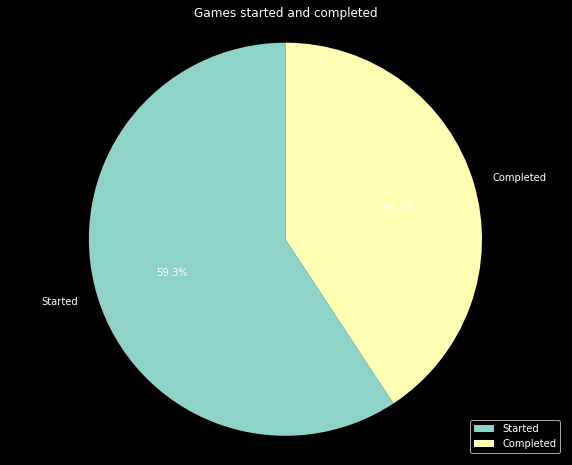

In [262]:
# pie chart of games started vs completed
figure1 = plt.figure()
labels = 'Started', 'Completed'
sizes = [games_started, games_completed]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend()
plt.title("Games started and completed")
plt.show()

## Game ending

### Number of players who have reached each specific game ending (of the 3 possible ones)

In [326]:
# count of games started and completed
ending_1 = 0
ending_2 = 0
ending_3 = 0

for key in players_info.keys():
    if players_info[key]["ending"]==1:
        ending_1 += 1
    elif players_info[key]["ending"]==2:
        ending_2 += 1
    elif players_info[key]["ending"]==3:
        ending_3 +=1

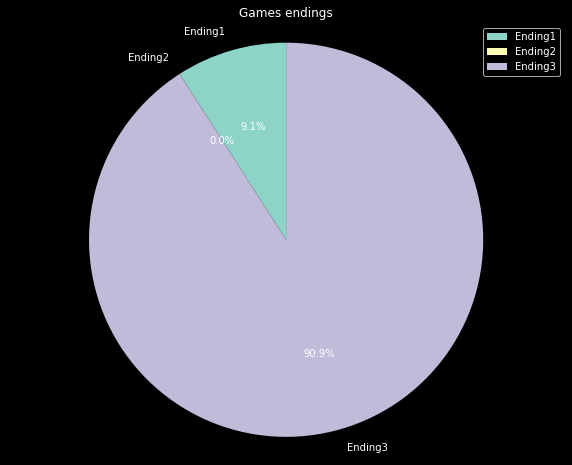

In [327]:
# pie chart of games started vs completed
figure1 = plt.figure()
labels = 'Ending1', 'Ending2', 'Ending3'
sizes = [ending_1, ending_2, ending_3]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend()
plt.title("Games endings")
plt.show()

## Progress of players

### Progress of players in the game over time

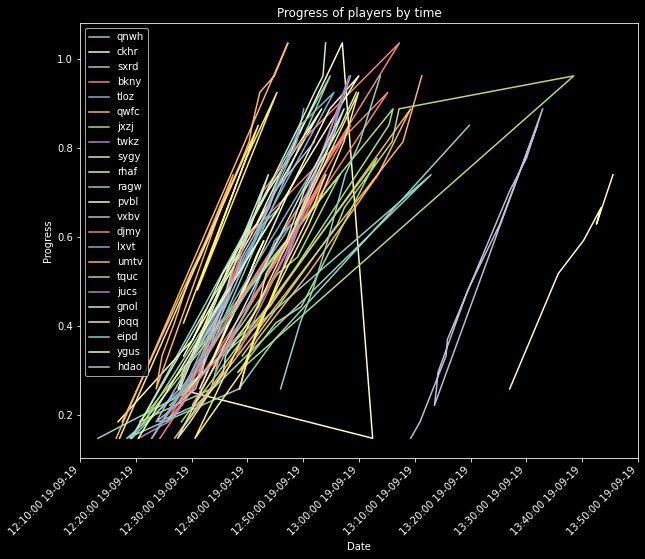

In [421]:
# line chart of progress of players by time

figure3 = plt.figure()

for player in players_info.keys():
    if players_info[player]["game_progress_per_time"] != []:
        progress_time = list(zip(*players_info[player]["game_progress_per_time"]))
        y = progress_time[0]
        x = progress_time[1]
        plt.plot(x,y, label=player)

plt.ylabel('Progress')
plt.xlabel('Date')
plt.xticks(rotation=45, ha="right")
left = datetime.fromisoformat('2019-09-19T12:10:00')
right = datetime.fromisoformat('2019-09-19T13:50:00')
plt.gca().set_xbound(left, right)
plt.legend(loc = 'best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S %d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.title("Progress of players by time")
plt.show()

## Day in-game reached

### Progress in in-game days for each player over time

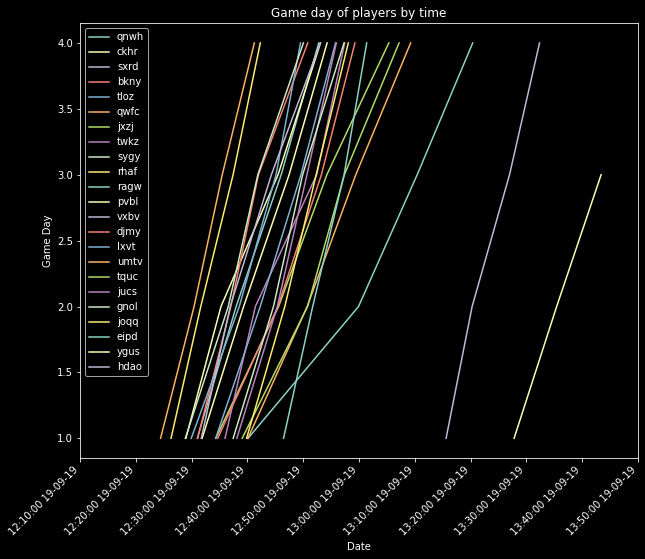

In [436]:
figure4 = plt.figure()

for player in players_info.keys():
    if players_info[player]["game_day_per_time"] != []:
        gameday_time = players_info[player]["game_day_per_time"]
        y = list(gameday_time.keys())
        x = list(gameday_time.values())
        
        N = len(x)
        for i in range(N):
            x[i] = datetime.strptime(x[i], '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.plot(x,y, label=player)

plt.ylabel('Game Day')
plt.xlabel('Date')
plt.xticks(rotation=45, ha="right")
left = datetime.fromisoformat('2019-09-19T12:10:00')
right = datetime.fromisoformat('2019-09-19T13:50:00')
plt.gca().set_xbound(left, right)
plt.legend(loc = 'best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S %d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.title("Game day of players by time")
plt.show()

## Game scene reached

### Maximum scene reached (out of the 25 scenes in the game) for each player

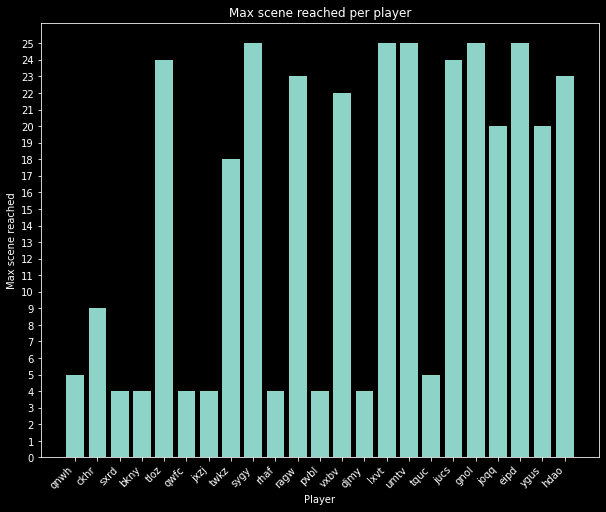

In [469]:
N = len(players_info)
ind = np.arange(N)
scenes = []

for p in players_info.keys():
    scenes.append(players_info[p]["max_scene"])

width = 0.35

plt.bar(ind, scenes)
plt.xlabel("Player")
plt.ylabel("Max scene reached")
plt.xticks(rotation=45, ha="right")
plt.xticks(ind, players_info.keys())
plt.yticks(np.arange(0, 26, 1))
plt.title("Max scene reached per player")
plt.show()

## Interactions

### Number of interactions with game objects, items and NPCs for each player

In [320]:
def heatMap(multiTab, ticksXlabel, ticksYlabel):
    fig, ax = plt.subplots(figsize=(len(ticksXlabel)*3,len(ticksYlabel)*2))
    im = ax.imshow(multiTab, cmap='cool', interpolation='nearest')
    for i in range(len(ticksYlabel)):
        for j in range(len(ticksXlabel)):
            text = ax.text(j, i, multiTab[i][j], fontsize=min(len(ticksXlabel),len(ticksYlabel)),
                       ha="center", va="center", color="b")
    cbar=plt.colorbar(im)
    cbar.ax.tick_params(labelsize=len(ticksYlabel))
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(ticksXlabel)))
    ax.set_yticks(np.arange(len(ticksYlabel)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(ticksXlabel, fontsize=len(ticksYlabel))
    ax.set_yticklabels(ticksYlabel, fontsize=len(ticksYlabel))
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

In [321]:
def constructHeatMap(players_info, playersSelected, labels, action, typ=False):
    multiList=[]
    i=0
    for label in labels:
        multiList.insert(i,[])
        j=0
        for player in playersSelected:
            if typ:
                nb=0
                for key in players_info[player][action].keys():
                    if label==key:
                        nb+=players_info[player][action][key]
                multiList[i].insert(j,nb)
            else:
                for key in players_info[player][action].keys():
                    if label==key:
                        multiList[i].insert(j,len(players_info[player][action][key]))
                    else:
                        multiList[i].insert(j,0)
            j+=1
        multiList[i]=list(multiList[i])
        i+=1
    return multiList

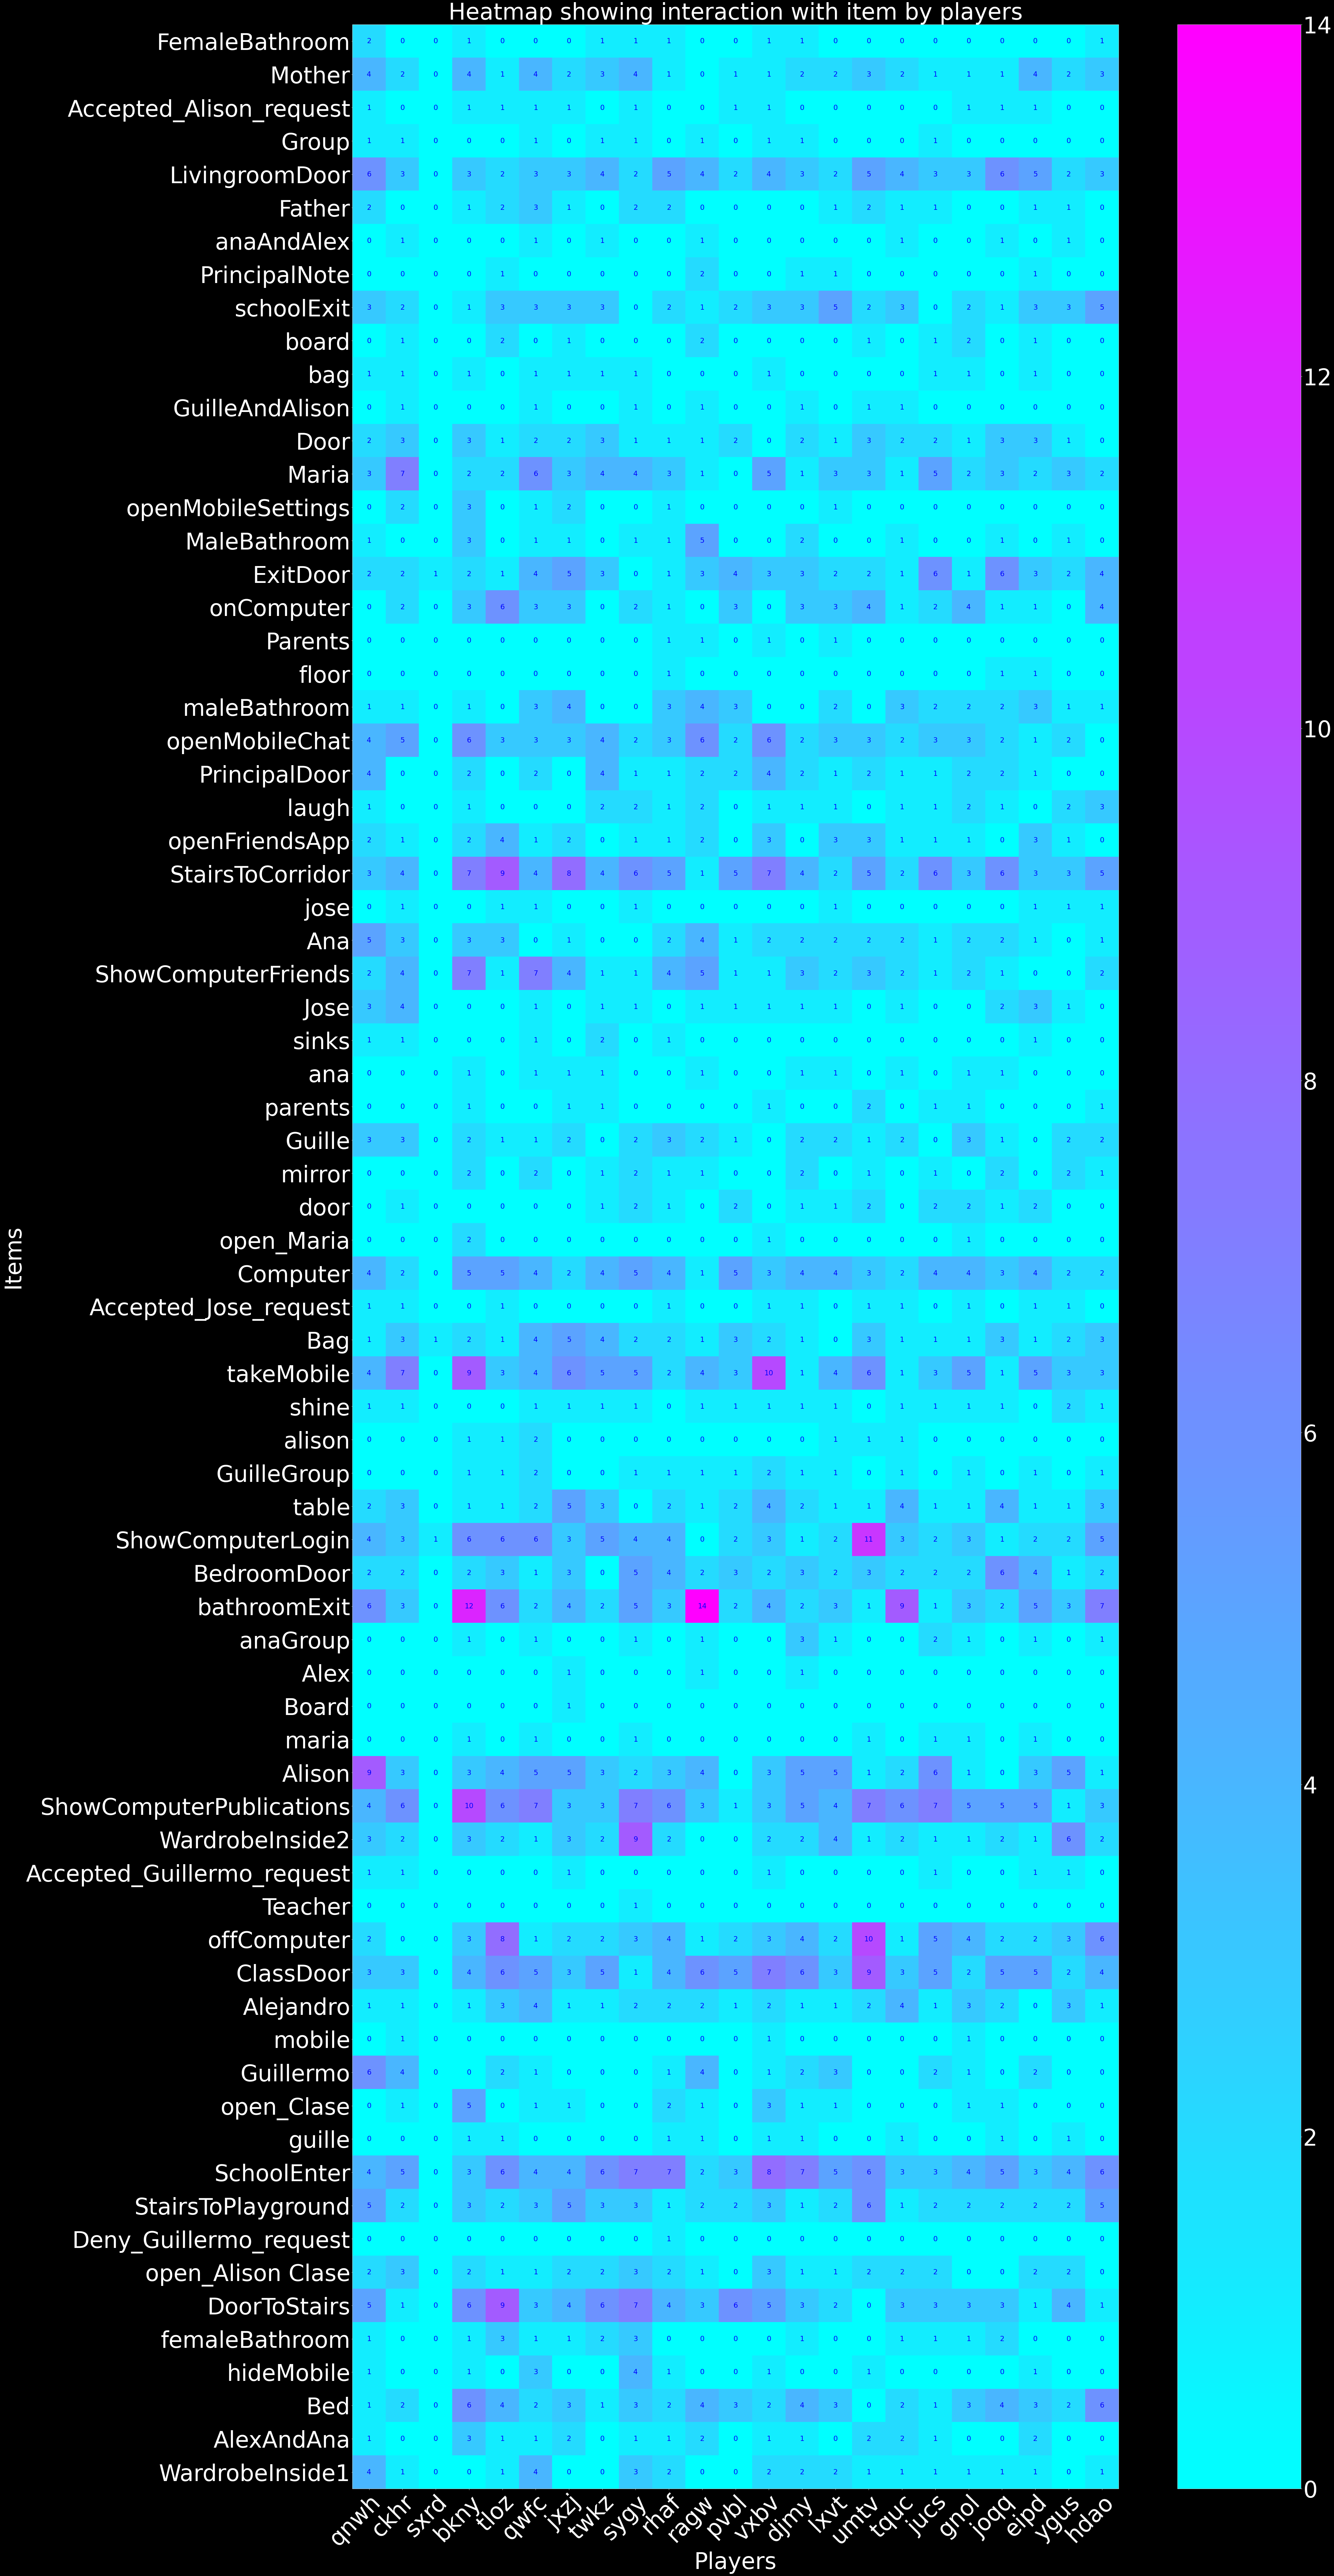

In [323]:
label_players=list(players_info.keys())

items = []

for player in label_players:
    items.extend(list(players_info[player]['interactions'].keys()))
    
items = set(items)

label_items=list(items)

nbitems=constructHeatMap(players_info, label_players, label_items, "interactions", True)

## Now use the heatmap function to plot the results
if len(label_players)>0 and len(label_items)>0:
    heatMap(nbitems, label_players, label_items)
    font=len(label_items)
else:
    noDataToFillVis(10)
    font=10
plt.xlabel("Players", fontsize=font)
plt.ylabel("Items", fontsize=font)
plt.title("Heatmap showing interaction with item by players", fontsize=font)
plt.show()

## Choices in alternatives

### Explore players' choices in a specific game alternative

After sitting in a gum in your chair, you can decide whether to:
- clean the gum
- leave it like that

In [483]:
clean_gum = 0
leave_gum = 0

for p in players_info.keys():
    if players_info[p]['clean_gum']:
        clean_gum += 1
    else:
        leave_gum += 1

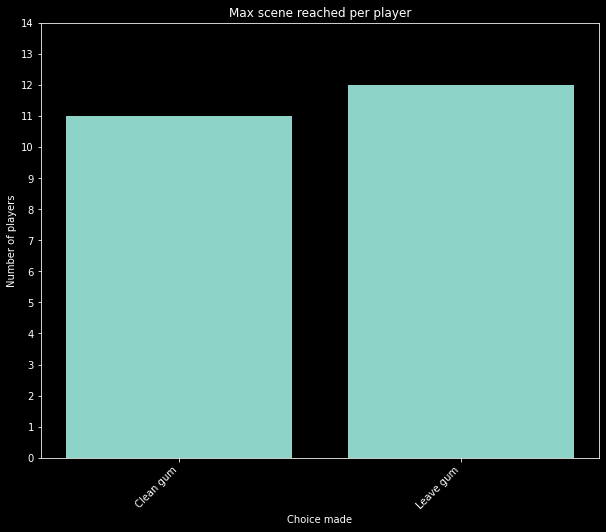

In [487]:
N = 2
ind = np.arange(N)
width = 0.35

choices = [clean_gum, leave_gum]

plt.bar(ind, choices)
plt.xlabel("Choice made")
plt.ylabel("Number of players")
plt.xticks(rotation=45, ha="right")
plt.xticks(ind, ['Clean gum', 'Leave gum'])
plt.yticks(np.arange(0, 15, 1))
plt.title("Max scene reached per player")
plt.show()